In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Concatenate, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

######## SEED setzen
import random
# Random Seed setzen:
random.seed(49)
np.random.seed(49)
SEED = 49

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

2.16.1
Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### SINGLE LABEL Experiment mit LSTM

In [3]:
single_lable = pd.read_csv('Preprocess-Data/preprocessed_single_label.csv')
single_lable.head()

,Unnamed: 0,Titel,Lyric,Artist,Genres
0,1719,I Miss Her,oh lord id like know thinks oh oh lord wanna g...,Olodum,Axé
1,1766,They Don't Care About Us,skin head dead head everybody gone bad situati...,Olodum,Axé
2,2586,Loved You Right Away,moment saw minute met wonderful feeling never ...,Carlinhos Brown,Axé
3,2627,Goodbye Hello,alone time feel blues way inventions invention...,Carlinhos Brown,Axé
4,2640,Mess In The Freeway,wanna tell wonderful things wanna tell interes...,Carlinhos Brown,Axé


In [4]:
single_lable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42760 entries, 0 to 42759
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42760 non-null  int64 
 1   Titel       42758 non-null  object
 2   Lyric       42758 non-null  object
 3   Artist      42760 non-null  object
 4   Genres      42760 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [5]:
# Entfernen der nicht benötigten Spalte
single_data = single_lable.drop(columns=['Unnamed: 0'])

single_data['Lyric'] = single_data['Lyric'].astype(str)
# Umwandlung aller Texte in Kleinbuchstaben (falls noch nicht geschehen)
single_data['Lyric'] = single_data['Lyric'].str.lower()

In [6]:
# Identifizieren der meist vorkommenden Genres
top_genres = single_data['Genres'].value_counts().nlargest(5).index
genres = ['Gospel/Religioso', 'Jazz', 'Pop/Rock', 'Rock', 'Pop', 'Rap', 'Punk Rock']
filtered_data = single_data[single_data['Genres'].isin(genres)]

filtered_data.head()

,Titel,Lyric,Artist,Genres
8150,Receive The Power - Jornada Mundial 2008,every nation every tribe come together worship...,Canção Nova,Gospel/Religioso
8151,By Faith,faith see faith reach faith live faith faith h...,André Valadão,Gospel/Religioso
8152,God Is Smiling,god smiling andré valadão open gates love turn...,André Valadão,Gospel/Religioso
8153,Here I Am To Worship,light world stepped darkness open eyes let see...,André Valadão,Gospel/Religioso
8154,Here I Am To Worship (Bossa),light world stepped darkness open eyes let see...,André Valadão,Gospel/Religioso


In [7]:
# Feature-Extraktion
filtered_data['word_count'] = filtered_data['Lyric'].apply(lambda x: len(x.split()))
filtered_data['avg_word_length'] = filtered_data['Lyric'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
filtered_data['unique_words'] = filtered_data['Lyric'].apply(lambda x: len(set(x.split())))

C:\Users\Leo\AppData\Local\Temp\ipykernel_1916\215376383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['word_count'] = filtered_data['Lyric'].apply(lambda x: len(x.split()))
C:\Users\Leo\AppData\Local\Temp\ipykernel_1916\215376383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['avg_word_length'] = filtered_data['Lyric'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0)
C:\Users\Leo\AppData\Local\Temp\ipykernel_1916\215376383.py:

In [8]:
# Vorbereitung der Labels
encoder = LabelEncoder()
filtered_data['Genres'] = encoder.fit_transform(filtered_data['Genres'])
labels = to_categorical(filtered_data['Genres'])

C:\Users\Leo\AppData\Local\Temp\ipykernel_1916\3848746753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Genres'] = encoder.fit_transform(filtered_data['Genres'])


In [9]:
# # Aufteilen der Daten in Trainings- und Testsets
# train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=SEED)

# Aufteilen der Daten in Trainings-, Validierungs- und Testsets
train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=SEED)  # 0.25 * 0.8 = 0.2

In [10]:
print('complete:',len(filtered_data))
print('train size:',len(train_data))
print('val size:', len(val_data))
print('test size:',len(test_data))

complete: 14699
train size: 8819
val size: 2940
test size: 2940


In [11]:
# Tokenizer vorbereiten und Texte zu Sequenzen umwandeln
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['Lyric'])
train_sequences = tokenizer.texts_to_sequences(train_data['Lyric'])
val_sequences = tokenizer.texts_to_sequences(val_data['Lyric'])
test_sequences = tokenizer.texts_to_sequences(test_data['Lyric'])

In [12]:
print(train_sequences[0])

[2542, 4171, 41, 1358, 4172, 1145, 147, 102, 382, 266, 5, 188, 1065, 957, 494, 232, 32, 673, 1339, 8, 2651, 3891, 8, 102, 3625, 54, 17643, 8, 1, 359, 29, 2243, 19, 84, 39, 37, 78, 29, 1, 8533, 23507, 184, 6122, 1, 292, 758, 1, 7967, 610, 1, 6411, 23508, 10041, 5392, 37, 2543, 585, 1, 7102, 3491, 1530, 10042, 23509, 23510, 9234, 1480, 1, 23511, 1128, 709, 3555, 2871, 2, 111, 32, 223, 155, 5866, 66, 1277, 5014, 4, 1860, 2318, 4539, 1841, 339, 113, 1129, 8, 2, 98, 1989, 7103, 90, 9235, 216, 117, 9235, 23512, 1001, 9, 7, 92, 758, 214, 26, 73, 1918, 84, 1, 385, 42, 92, 209, 428, 202, 843, 1640, 1278, 907, 23513, 2, 154, 34, 441, 23514, 8, 212, 12462, 16, 5, 8, 1390, 4, 14524, 8, 16, 653, 17644, 138, 8, 405, 6, 17644, 138, 8, 1380, 307, 592, 644, 63, 565, 8, 36, 285, 1429, 63, 565, 8, 8, 4078, 2872, 539, 6, 118, 14525, 445, 3285, 23515, 8, 23516, 10043, 17645, 8, 23517, 17646, 2346, 1371, 8, 329, 47, 272, 523, 57, 12, 78, 321, 1, 1823, 23518, 12, 401, 61, 11, 167, 114, 18, 1676, 1010, 810, 4

In [13]:
# Padding der Sequenzen, damit sie die gleiche Länge haben
max_length = max(train_data['word_count'].max(), val_data['word_count'].max(), test_data['word_count'].max())
train_padded = pad_sequences(train_sequences, maxlen=max_length)
val_padded = pad_sequences(val_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

In [14]:
# Feature-Matrix
train_features = train_data[['word_count', 'avg_word_length', 'unique_words']].values
val_features = val_data[['word_count', 'avg_word_length', 'unique_words']].values
test_features = test_data[['word_count', 'avg_word_length', 'unique_words']].values

In [15]:
from tensorflow.keras.utils import to_categorical

# Kodiere die Labels in One-Hot-Format
train_labels = to_categorical(train_data['Genres'])
val_labels = to_categorical(val_data['Genres'])
test_labels = to_categorical(test_data['Genres'])

In [16]:
# # Labels kodieren
# encoder = LabelEncoder()
# encoder.fit(train_data['Genres'])
# train_labels = encoder.transform(train_data['Genres'])
# test_labels = encoder.transform(test_data['Genres'])

In [17]:
# # Labels zu Kategorien konvertieren
# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

In [18]:
# LSTM Modell
input_text = Input(shape=(max_length,))
input_features = Input(shape=(3,))
embedded_text = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100)(input_text)
lstm_out = LSTM(100)(embedded_text)
concatenated = Concatenate()([lstm_out, input_features])
output = Dense(units=labels.shape[1], activation='softmax')(concatenated)
model = Model(inputs=[input_text, input_features], outputs=output)

In [19]:
# # LSTM-Modell definieren
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_length))
# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(units=train_labels.shape[1], activation='softmax'))

In [20]:
# Kompilieren 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [21]:
# Modell kompilieren
# EarlyStopping Callback definieren
# early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Modell trainieren
# history = model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels), verbose=1, callbacks=[early_stopping])
history = model.fit([train_padded, train_features], train_labels, 
          validation_data=([val_padded, val_features], val_labels), 
          epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 206s 735ms/step - accuracy: 0.1588 - loss: 24.6844 - val_accuracy: 0.3776 - val_loss: 3.3484
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 205s 744ms/step - accuracy: 0.3971 - loss: 2.9967 - val_accuracy: 0.4316 - val_loss: 1.9669
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 206s 746ms/step - accuracy: 0.4559 - loss: 1.6754 - val_accuracy: 0.4867 - val_loss: 1.4940
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 206s 745ms/step - accuracy: 0.5791 - loss: 1.2441 - val_accuracy: 0.4731 - val_loss: 1.4383
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 204s 740ms/step - accuracy: 0.6781 - loss: 0.9472 - val_accuracy: 0.5068 - val_loss: 1.4159
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 202s 732ms/step - accuracy: 0.7520 - loss: 0.7322 - val_accuracy: 0.5048 - val_loss: 1.4492
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 197s 713ms/step - accuracy: 0.8225 - loss: 0.5400 - val_accuracy: 0.5395 - val_loss: 1.5120
Epoch 7: early stopping


In [23]:
# Helper function to plot the history of a model
def plot_history(history):
    print(history.history.keys())
    epochs = range(1, len(history.history['accuracy']) + 1)
    # summarize history for accuracy
    plt.plot(epochs, history.history['accuracy'], 'o-', label='Training accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'o-', label='Validation accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(loc='upper left')
    plt.show()
    # summarize history for loss, start from second epoch, cause the first is always too high
    plt.plot(epochs[1:], history.history['loss'][1:], 'o-', label='Training loss')
    plt.plot(epochs[1:], history.history['val_loss'][1:], 'o-', label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs[1:])  # Adjust x-axis to start from second epoch
    plt.legend(loc='upper left')
    plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


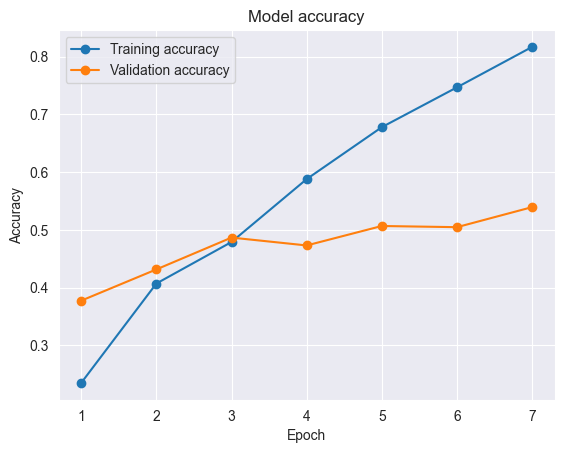

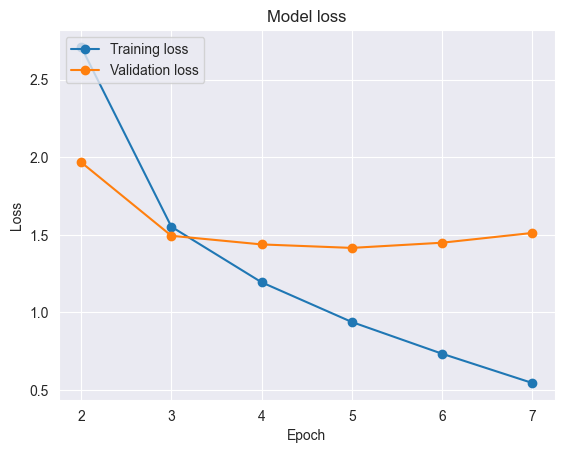

In [24]:
plot_history(history)

In [25]:
# loss, accuracy = model.evaluate(test_padded, test_labels, verbose=1)
test_loss, test_accuracy = model.evaluate([test_padded, test_features], test_labels)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 0.5401 - loss: 1.5532
Test Accuracy: 54.25%
Test Loss: 1.5554


In [26]:
# predictions = model.predict(test_padded)
# predicted_labels = predictions.argmax(axis=1)  # Umwandlung der One-Hot-Encoded-Vorhersagen in Label-Indizes

# Vorhersagen machen
predictions = model.predict([test_padded, test_features])
predicted_labels = predictions.argmax(axis=1)

# Echte Labels für Vergleich
true_labels = test_data['Genres'].values

92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step


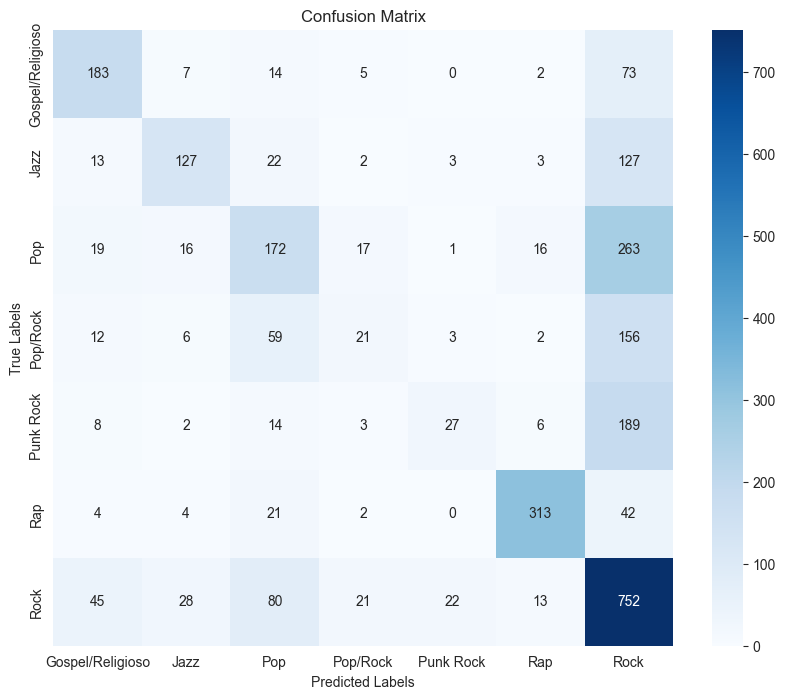

In [27]:

# true_labels = test_labels.argmax(axis=1)  # Umwandlung der tatsächlichen One-Hot-Encoded-Labels in Label-Indizes
cm = confusion_matrix(true_labels, predicted_labels)

# Konfusionsmatrix plotten
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [28]:
report = classification_report(true_labels, predicted_labels, target_names=encoder.classes_)
print(report)

                  precision    recall  f1-score   support

Gospel/Religioso       0.64      0.64      0.64       284
            Jazz       0.67      0.43      0.52       297
             Pop       0.45      0.34      0.39       504
        Pop/Rock       0.30      0.08      0.13       259
       Punk Rock       0.48      0.11      0.18       249
             Rap       0.88      0.81      0.84       386
            Rock       0.47      0.78      0.59       961

        accuracy                           0.54      2940
       macro avg       0.56      0.46      0.47      2940
    weighted avg       0.54      0.54      0.51      2940


In [29]:
# sample_texts = test_data['Lyric'].iloc[:10]  # Auswahl einiger Beispielsongtexte
# sample_labels = test_labels[:10]
# sample_predictions = model.predict(pad_sequences(tokenizer.texts_to_sequences(sample_texts), maxlen=max_length))
# 
# for i, text in enumerate(sample_texts):
#     true_label = encoder.classes_[sample_labels[i].argmax()]
#     predicted_label = encoder.classes_[sample_predictions[i].argmax()]
#     print(f"Lyric: {text[:50]}... \nTrue Genre: {true_label}, Predicted Genre: {predicted_label}\n")

# Optional: Ausgabe einiger Vorhersagen
for i in range(10):  # Anzeigen von 10 Vorhersagen
    print(f"Lyric: {test_data['Lyric'].iloc[i][:50]}...")  # Zeige ersten 50 Zeichen des Lyrics
    print(f"Predicted Genre: {encoder.inverse_transform([predicted_labels[i]])[0]}, True Genre: {encoder.inverse_transform([true_labels[i]])[0]}\n")

Lyric: line drawn sand way nowhere land youve never seen ...
Predicted Genre: Rock, True Genre: Rock

Lyric: hook wanted love looking romeo instead found thugg...
Predicted Genre: Rap, True Genre: Rap

Lyric: promised ending would clear youd let know time don...
Predicted Genre: Rock, True Genre: Rock

Lyric: water wide cant cross neither got wings fly give b...
Predicted Genre: Rock, True Genre: Rock

Lyric: dreamed city called glory bright fair entered gate...
Predicted Genre: Gospel/Religioso, True Genre: Gospel/Religioso

Lyric: many many year ago kingdom sea maiden lived may kn...
Predicted Genre: Pop, True Genre: Rock

Lyric: yankee soldier wanna shoot skag met cambodia cant ...
Predicted Genre: Rock, True Genre: Punk Rock

Lyric: yeah oooh yeah yeah yeah yeah ohh im standing club...
Predicted Genre: Pop, True Genre: Pop

Lyric: got room top world tonight see everything tonight ...
Predicted Genre: Rock, True Genre: Rock

Lyric: yo im ready go got rhymes flow pull plug set ya st.